In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm_notebook
import pickle

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

/home/claudia/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/claudia/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
df = pd.read_csv("Py_Dataset.csv")
staz = pd.read_csv("Stazioni_Emilia.csv")
dummies = pd.get_dummies(df.Tipo)

In [3]:
normal_cluster = """
data {
    int<lower=0> N; 
    int<lower=0> p;
    int<lower=0> G;
    int<lower=0> C;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    int stazione[N];
    real omega;
    row_vector[2] coord[G];
}

parameters {
    
    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    matrix[G, 2] A;
    
    vector[G] w;
    real<lower=0> rho;
    real<lower=0> alpha;
    
    
    vector<lower=0>[C] sigma_l_sq;
    matrix[C,2] mu_l;
    vector<lower=0, upper=1>[C-1] v;
    
    
}


transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma_sq);
    
    vector<lower=0>[C] sigma_l;
    sigma_l = sqrt(sigma_l_sq);
    
    vector[N] ft;
    ft = to_vector(rep_array(0, N));
    ft[1:N] += (  rows_dot_product(A[stazione[1:N],1],sin(omega*t[1:N])) 
                + rows_dot_product(A[stazione[1:N],2],cos(omega*t[1:N]))  );

    vector[N] mu;
    mu = ft + X*beta ;
    mu[1:N] += w[stazione[1:N]];
         
    cov_matrix[G] H = cov_exp_quad(coord, alpha, rho);
    
    vector<lower=0, upper=1> [C-1] cumprod_one_minus_v;
    cumprod_one_minus_v = exp(cumulative_sum(log1m(v)));
    simplex[C] eta;
    eta[1] = v[1];
    eta[2:(C-1)] = v[2:(C-1)] .*cumprod_one_minus_v[1:(C-2)];
    eta[C] = cumprod_one_minus_v[C - 1];
    
    
    real param=2.0;
}


model {  

    sigma_sq ~ inv_gamma(3,2);
    
    beta ~ normal([-0.1, -0.1, 0.1], 1);
    
    rho ~ beta(10, 2000);
    
    w ~ multi_normal(rep_vector(0,G), H);
    
    Y ~ normal(mu, sigma);  
    
    
    for (i in 1:C){
         mu_l[i, :] ~ multi_normal(rep_vector(0,2), diag_matrix(rep_vector(2,2)));
         }
         
    sigma_l_sq ~ inv_gamma(10,9);
    
    v ~ beta(1, param);
    
    
    for (g in 1:G){
        vector[C] lps = log(eta);
        for (k in 1:C)
            lps[k] += normal_lpdf(A[g, :] | mu_l[k,:], sigma_l[k]);
        target += log_sum_exp(lps);
        }
}


generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sigma);
  }
  
  
  int cluster_allocs[G];
  for(g in 1:G){
  // kernel discreta di i in k
  vector[C] log_probs = log(eta);
  for (k in 1:C)
     log_probs[k] += normal_lpdf(A[g, :] | mu_l[k,:], sigma_l[k]);
  cluster_allocs[g] = categorical_rng(softmax(log_probs));
  }
  
}
"""

stan_file = "./normal_cluster.stan"

with open(stan_file, "w") as f:
    print(normal_cluster, file=f)

normal_cluster = CmdStanModel(stan_file=stan_file)


INFO:cmdstanpy:compiling stan program, exe file: /home/claudia/Desktop/bayesian_project/Bayesian-Project/normal_cluster
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/claudia/Desktop/bayesian_project/Bayesian-Project/normal_cluster


In [6]:
y = np.array(df.Y_log)
x = np.matrix( pd.concat([df.quota, dummies.Fondo, dummies.Industriale], axis=1) )
t = np.array(df.Time)
r = np.array(df.Rural)
stazione = np.array(df.id)
omega = 2*np.pi/365
coord = np.matrix( pd.concat([staz.Lat, staz.Long], axis=1) )

N = len(y)
p = 3   # Quota + Tipo(2 dummies)
G = 49  # numero stazioni in Emilia-Romagna
C = 20  # numero cluster

In [7]:
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "p": p,   # 4
    "G": G,
    "C": C, # prova con 20
    
    "Y": y,
    "X": x, 
    "t": t,
    "stazione": stazione,
    "omega": omega,
    "coord": coord
}

fit_clust = normal_cluster.sample(data=reg_data, chains=2, parallel_chains=2, 
                             iter_warmup=30, iter_sampling=100, show_progress=True)



Chain 2 -   done: 100%|███████████████████████| 130/130 [04:37<00:00,  2.13s/it]


In [ ]:
normal_az = az.from_cmdstanpy(fit_clust)

In [ ]:
az.plot_trace(normal_az, var_names=["eta"], compact=False)
plt.show()

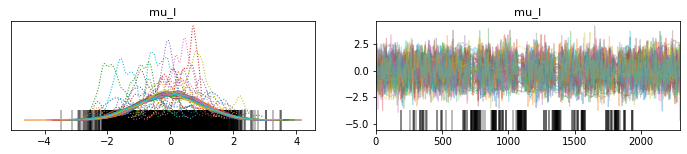

In [24]:
az.plot_trace(normal_az, var_names=["mu_l"], compact=True)
plt.show()


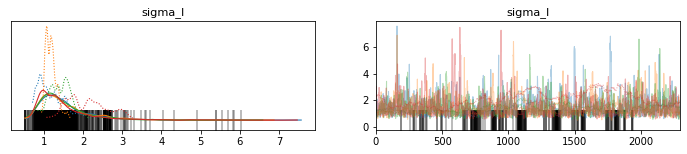

In [25]:
az.plot_trace(normal_az, var_names=["sigma_l"], compact=True)
plt.show()

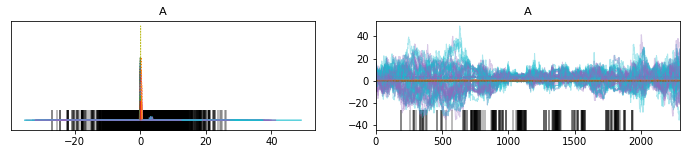

In [37]:
az.plot_trace(normal_az, var_names=["A"], compact=True)
plt.show()

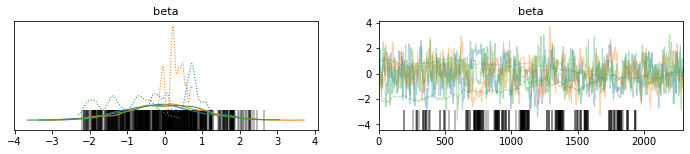

In [38]:
az.plot_trace(normal_az, var_names=["beta"], compact=True)
plt.show()

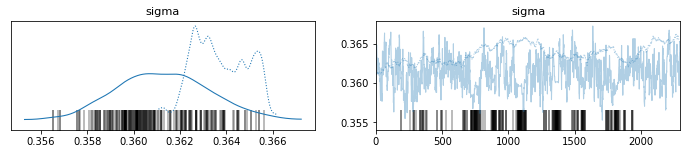

In [39]:
az.plot_trace(normal_az, var_names=["sigma"], compact=True)
plt.show()

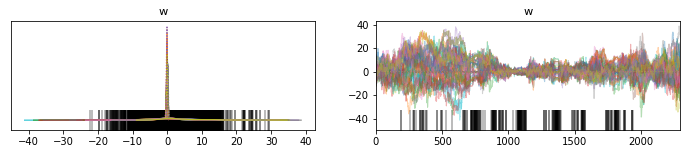

In [40]:
az.plot_trace(normal_az, var_names=["w"], compact=True)
plt.show()

In [8]:
# cluster allocation
output_clust = fit_clust.stan_variable('cluster_allocs')
output_clust.shape

(200, 49)

In [9]:
# prima iterazione : 1st chain
output_clust[5,:]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [10]:
# ultima iterazione : 1st chain
output_clust[99,:] 

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [11]:
# prima iterazione : 2nd chain
output_clust[100,:]

array([1., 1., 1., 1., 4., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
# ultima iterazione : 2nd chain
output_clust[199,:] 

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])